# Практическая работа к занятию №2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch import nn

In [2]:
!nvidia-smi

Mon Feb 28 19:51:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    74W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
batch_size = 512

train_transform = transforms.Compose([
                transforms.RandomRotation(degrees=10),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])


train_dataset = torchvision.datasets.CIFAR10(root='./data/', train=True,
                                              transform=train_transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data/', train=False,
                                             transform=test_transform, download=True)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=False)

classes = train_dataset.classes
num_classes = len(train_dataset.classes)

print(f"len train dataset: {len(train_dataset)}")
print(f"len test dataset: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")

Files already downloaded and verified
Files already downloaded and verified
len train dataset: 50000
len test dataset: 10000
Number of classes: 10


In [4]:
def plot_batch(batch):
    images, labels = batch
    num_images = len(images)
    fig, axes = plt.subplots(4, 8, figsize=(15, 10))
    axes = axes.flatten()
    
    for ax, image, label in zip(axes, images, labels):
        ax.axis('off')

        inp = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        ax.imshow(inp)
        ax.set_title(classes[label.numpy()])

    plt.show()

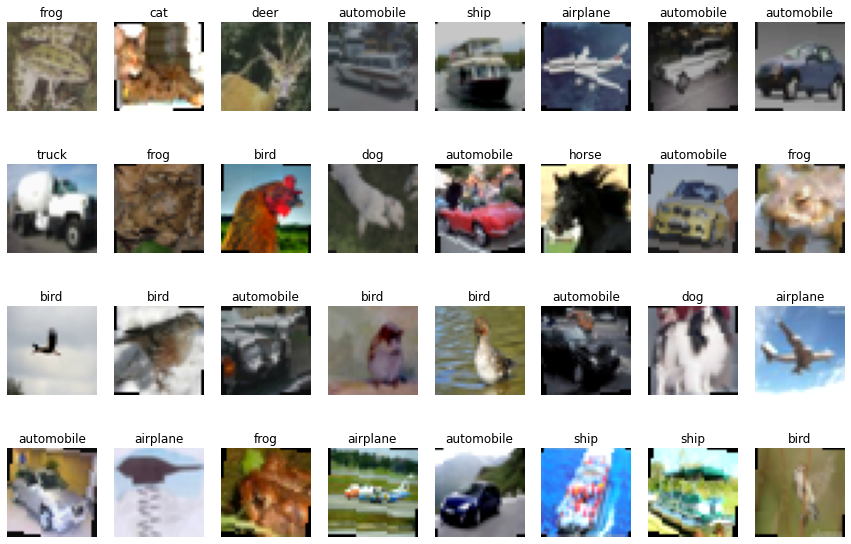

In [5]:
batch = next(iter(train_loader))
plot_batch(batch)

In [6]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.1)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.1)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.1)
        x = self.fc4(x)
        x = F.softmax(x, 1)
        
        return x

In [7]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.set_grad_enabled(True):
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [8]:
def test_epoch(model, train_loader, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc    

In [9]:
def train(model, train_loader, test_loader, criterion, optimizer, epochs):
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': []
    }
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[10, 20], gamma=0.5, verbose=True)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        test_loss, test_acc = test_epoch(model, test_loader, criterion)
        scheduler.step()

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"train_loss: {train_loss}; train_acc: {train_acc}; test_loss: {test_loss}; test_acc: {test_acc}")
    
    return history

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [11]:
model = Net(3 * 32 * 32, 128, num_classes)
model = model.to(DEVICE)

from torchsummary import summary

summary(model, batch[0].shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 10]           1,290
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 6.63
Estimated Total Size (MB): 6.65
----------------------------------------------------------------


In [12]:
epochs = 40

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = train(model, train_loader, test_loader, criterion, optimizer, epochs)

Adjusting learning rate of group 0 to 1.0000e-03.


  2%|▎         | 1/40 [01:24<55:10, 84.88s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
train_loss: 2.134274455413818; train_acc: 0.31742; test_loss: 2.094054553375244; test_acc: 0.3595


  5%|▌         | 2/40 [02:47<52:56, 83.60s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
train_loss: 2.0801496355438234; train_acc: 0.37484; test_loss: 2.063859663467407; test_acc: 0.39184


  8%|▊         | 3/40 [04:10<51:14, 83.09s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
train_loss: 2.0640882939910887; train_acc: 0.39204; test_loss: 2.0515240183258054; test_acc: 0.40366


 10%|█         | 4/40 [05:32<49:35, 82.66s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
train_loss: 2.05434619430542; train_acc: 0.40142; test_loss: 2.040839842147827; test_acc: 0.4159


 12%|█▎        | 5/40 [06:53<48:03, 82.40s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
train_loss: 2.0429288706970214; train_acc: 0.41418; test_loss: 2.0391982488250733; test_acc: 0.4169


 15%|█▌        | 6/40 [08:15<46:34, 82.19s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
train_loss: 2.039019126358032; train_acc: 0.41782; test_loss: 2.0351962860870363; test_acc: 0.42108


 18%|█▊        | 7/40 [09:37<45:10, 82.13s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
train_loss: 2.037237240524292; train_acc: 0.42016; test_loss: 2.039570498504639; test_acc: 0.41684


 20%|██        | 8/40 [10:59<43:42, 81.95s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
train_loss: 2.028954282836914; train_acc: 0.4276; test_loss: 2.0251893444061277; test_acc: 0.43252


 22%|██▎       | 9/40 [12:20<42:14, 81.77s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
train_loss: 2.025396482620239; train_acc: 0.43154; test_loss: 2.024403571815491; test_acc: 0.43284


 25%|██▌       | 10/40 [13:41<40:46, 81.55s/it]

Adjusting learning rate of group 0 to 5.0000e-04.
train_loss: 2.0194814099502563; train_acc: 0.43838; test_loss: 2.0181638948059084; test_acc: 0.43928


 28%|██▊       | 11/40 [15:04<39:35, 81.90s/it]

Adjusting learning rate of group 0 to 5.0000e-04.
train_loss: 2.0029169968414307; train_acc: 0.45382; test_loss: 1.9938888229751588; test_acc: 0.46414


 30%|███       | 12/40 [16:27<38:22, 82.24s/it]

Adjusting learning rate of group 0 to 5.0000e-04.
train_loss: 1.9914124150085448; train_acc: 0.46624; test_loss: 1.983640038909912; test_acc: 0.47406


 32%|███▎      | 13/40 [17:50<37:07, 82.52s/it]

Adjusting learning rate of group 0 to 5.0000e-04.
train_loss: 1.9874369869232178; train_acc: 0.46954; test_loss: 1.9784945249176025; test_acc: 0.47872


 35%|███▌      | 14/40 [19:13<35:49, 82.65s/it]

Adjusting learning rate of group 0 to 5.0000e-04.
train_loss: 1.9852783628845214; train_acc: 0.4726; test_loss: 1.9752669481277465; test_acc: 0.48264


 38%|███▊      | 15/40 [20:37<34:35, 83.02s/it]

Adjusting learning rate of group 0 to 5.0000e-04.
train_loss: 1.977611037902832; train_acc: 0.4799; test_loss: 1.9753520071792603; test_acc: 0.48192


 40%|████      | 16/40 [22:01<33:17, 83.25s/it]

Adjusting learning rate of group 0 to 5.0000e-04.
train_loss: 1.9719008103179931; train_acc: 0.48542; test_loss: 1.9663276778411864; test_acc: 0.49108


 42%|████▎     | 17/40 [23:24<31:56, 83.34s/it]

Adjusting learning rate of group 0 to 5.0000e-04.
train_loss: 1.968351445236206; train_acc: 0.48918; test_loss: 1.9674970419692994; test_acc: 0.49028


 45%|████▌     | 18/40 [24:48<30:34, 83.39s/it]

Adjusting learning rate of group 0 to 5.0000e-04.
train_loss: 1.9665277418899536; train_acc: 0.49104; test_loss: 1.9601534547424317; test_acc: 0.4972


 48%|████▊     | 19/40 [26:12<29:13, 83.51s/it]

Adjusting learning rate of group 0 to 5.0000e-04.
train_loss: 1.961438437309265; train_acc: 0.49714; test_loss: 1.9608265940856933; test_acc: 0.4967


 50%|█████     | 20/40 [27:35<27:50, 83.55s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9578123085021972; train_acc: 0.49966; test_loss: 1.9547520974731445; test_acc: 0.5033


 52%|█████▎    | 21/40 [28:58<26:25, 83.45s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9471947848510742; train_acc: 0.51126; test_loss: 1.9437350375366211; test_acc: 0.51418


 55%|█████▌    | 22/40 [30:22<25:01, 83.41s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9409836192321777; train_acc: 0.5172; test_loss: 1.937143760871887; test_acc: 0.52108


 57%|█████▊    | 23/40 [31:44<23:34, 83.19s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.937136170387268; train_acc: 0.5214; test_loss: 1.9393749185180664; test_acc: 0.51902


 60%|██████    | 24/40 [33:07<22:05, 82.86s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9381547425460814; train_acc: 0.51998; test_loss: 1.9324392740249634; test_acc: 0.52642


 62%|██████▎   | 25/40 [34:28<20:38, 82.53s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9340598085403442; train_acc: 0.52492; test_loss: 1.931053048362732; test_acc: 0.52738


 65%|██████▌   | 26/40 [35:50<19:11, 82.27s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9310648326873778; train_acc: 0.5272; test_loss: 1.9281626682662965; test_acc: 0.53026


 68%|██████▊   | 27/40 [37:12<17:48, 82.20s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9319150477600098; train_acc: 0.5267; test_loss: 1.9295893285751342; test_acc: 0.5295


 70%|███████   | 28/40 [38:34<16:24, 82.01s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9279299471664428; train_acc: 0.52992; test_loss: 1.9268455917739868; test_acc: 0.53218


 72%|███████▎  | 29/40 [39:55<14:58, 81.71s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.927356888771057; train_acc: 0.53072; test_loss: 1.9244489197158814; test_acc: 0.53444


 75%|███████▌  | 30/40 [41:16<13:36, 81.65s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.923821946144104; train_acc: 0.53472; test_loss: 1.9200927451705934; test_acc: 0.53852


 78%|███████▊  | 31/40 [42:38<12:15, 81.71s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9214820394134522; train_acc: 0.53752; test_loss: 1.9187986081314088; test_acc: 0.54016


 80%|████████  | 32/40 [44:00<10:55, 81.91s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9190823483657837; train_acc: 0.53978; test_loss: 1.9145431664276122; test_acc: 0.54452


 82%|████████▎ | 33/40 [45:23<09:34, 82.11s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9165730714416505; train_acc: 0.54214; test_loss: 1.910586773338318; test_acc: 0.54818


 85%|████████▌ | 34/40 [46:45<08:12, 82.06s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9130086131668091; train_acc: 0.54606; test_loss: 1.911450136680603; test_acc: 0.54708


 88%|████████▊ | 35/40 [48:07<06:49, 81.97s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9124005533218384; train_acc: 0.5473; test_loss: 1.9067538209533692; test_acc: 0.5537


 90%|█████████ | 36/40 [49:28<05:27, 81.87s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9093955811309815; train_acc: 0.55022; test_loss: 1.9042801657867432; test_acc: 0.55556


 92%|█████████▎| 37/40 [50:51<04:06, 82.00s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9096084180450439; train_acc: 0.5498; test_loss: 1.9066472462844848; test_acc: 0.55256


 95%|█████████▌| 38/40 [52:13<02:43, 81.99s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.906640068397522; train_acc: 0.5527; test_loss: 1.900924249534607; test_acc: 0.5584


 98%|█████████▊| 39/40 [53:35<01:22, 82.00s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.905775126838684; train_acc: 0.5532; test_loss: 1.9023011105346679; test_acc: 0.5576


100%|██████████| 40/40 [54:57<00:00, 82.43s/it]

Adjusting learning rate of group 0 to 2.5000e-04.
train_loss: 1.9015379467010498; train_acc: 0.55766; test_loss: 1.8973054139709473; test_acc: 0.5623


In [28]:
def predict(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())
    
    return (np.concatenate(y_true, axis=0), 
            np.concatenate(y_pred, axis=0))

In [29]:
y_true, y_pred = predict(model, test_loader)

100%|██████████| 98/98 [00:44<00:00,  2.21it/s]


In [30]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

              precision    recall  f1-score   support

    airplane       0.61      0.59      0.60      5000
  automobile       0.64      0.67      0.65      5000
        bird       0.49      0.45      0.47      5000
         cat       0.42      0.43      0.42      5000
        deer       0.53      0.47      0.50      5000
         dog       0.48      0.42      0.45      5000
        frog       0.56      0.61      0.59      5000
       horse       0.60      0.66      0.63      5000
        ship       0.66      0.69      0.68      5000
       truck       0.61      0.64      0.63      5000

    accuracy                           0.56     50000
   macro avg       0.56      0.56      0.56     50000
weighted avg       0.56      0.56      0.56     50000

